Esse notebook é uma cópia direta do svd_second_testing, e pretende explorar a condição das matrizes do MPM

In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i:met_i + 1], t2s[met_i:met_i + 1], M_0s[met_i:met_i + 1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


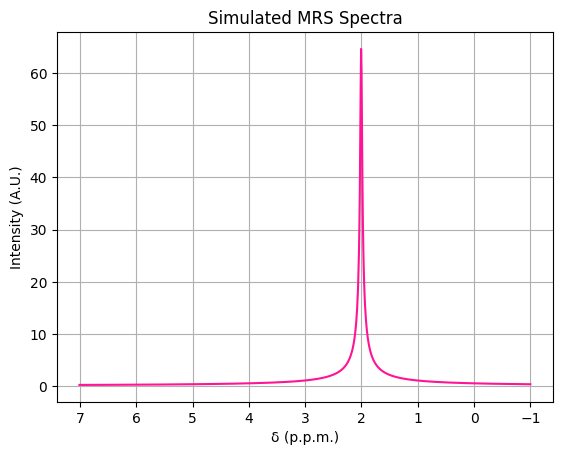

In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [4]:
L = 0.4
L_ = int(L*sig.size)
rcond = 1e-15
zero_filtering=1e-30

In [5]:
noise_threshold = np.arange(1.5, 1.8, 0.03)
# noise_threshold = np.array([1.65])
sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])
print(np.power(10.0, -noise_threshold))

[0.03162278 0.02951209 0.02754229 0.02570396 0.02398833 0.02238721
 0.02089296 0.01949845 0.01819701 0.01698244 0.01584893]


In [6]:
n_avgs = 10
shape = (noise_threshold.size, n_avgs)
y1_cond, a_cond, zs_cond = np.zeros(shape), np.zeros(shape), np.zeros(shape)


In [7]:
SNR = sample_snrs[3]
print(SNR)

1.0


In [8]:
rerun = False
save = False
filename_end = "_" + str(int(SNR))
folder_name = "files/"
subfolder_name = "matrix_condition/"

In [9]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)
sig, t = pymri.population_transverse_decay(t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft_ = sig_fft/np.nanmax(sig_fft)

if rerun == True:
    for j in range(n_avgs):
        c_sig_fft = awgn(sig_fft_, SNR)
        c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

        for i in range(noise_threshold.size):

            print(noise_threshold[i])
            y1_cond[i, j], a_cond[i, j], zs_cond[i, j] = pymri.assess_conditions(c_sig, L, noise_threshold[i],
                                                                                    rcond=rcond, 
                                                                                    zero_filtering=zero_filtering)
        print("--" + str(j) + "--")

In [10]:
if rerun == True and save == True:
    np.save(folder_name + subfolder_name + "y1_cond" + filename_end, y1_cond)
    np.save(folder_name + subfolder_name + "a_cond" + filename_end, a_cond)
    np.save(folder_name + subfolder_name + "zs_cond" + filename_end, zs_cond)

In [11]:
if rerun == False:
    y1_cond = np.load(folder_name + subfolder_name   + "y1_cond" + filename_end + ".npy")
    a_cond  = np.load(folder_name + subfolder_name   + "a_cond"  + filename_end + ".npy")
    zs_cond = np.load(folder_name + subfolder_name   + "zs_cond" + filename_end + ".npy")


In [12]:
avg_y1_cond = np.average(y1_cond, axis = 1)
avg_a_cond = np.average(a_cond, axis = 1)
avg_zs_cond = np.average(zs_cond, axis = 1)

std_y1_cond = np.std(y1_cond, axis = 1)
std_a_cond = np.std(a_cond, axis = 1)
std_zs_cond = np.std(zs_cond, axis = 1)

min_y1_cond = np.min(y1_cond, axis = 1)
min_a_cond = np.min(a_cond, axis = 1)
min_zs_cond = np.min(zs_cond, axis = 1)

max_y1_cond = np.max(y1_cond, axis = 1)
max_a_cond = np.max(a_cond, axis = 1)
max_zs_cond = np.max(zs_cond, axis = 1)

In [21]:
print(zs_cond[8, :])

[1.11879709e+024 3.19180688e+148 1.90265311e+022 7.49502793e+006
 1.78735312e+020 6.73418307e+022 8.59764828e+026 1.17476103e+024
 4.03963579e+020 4.24490713e+023]


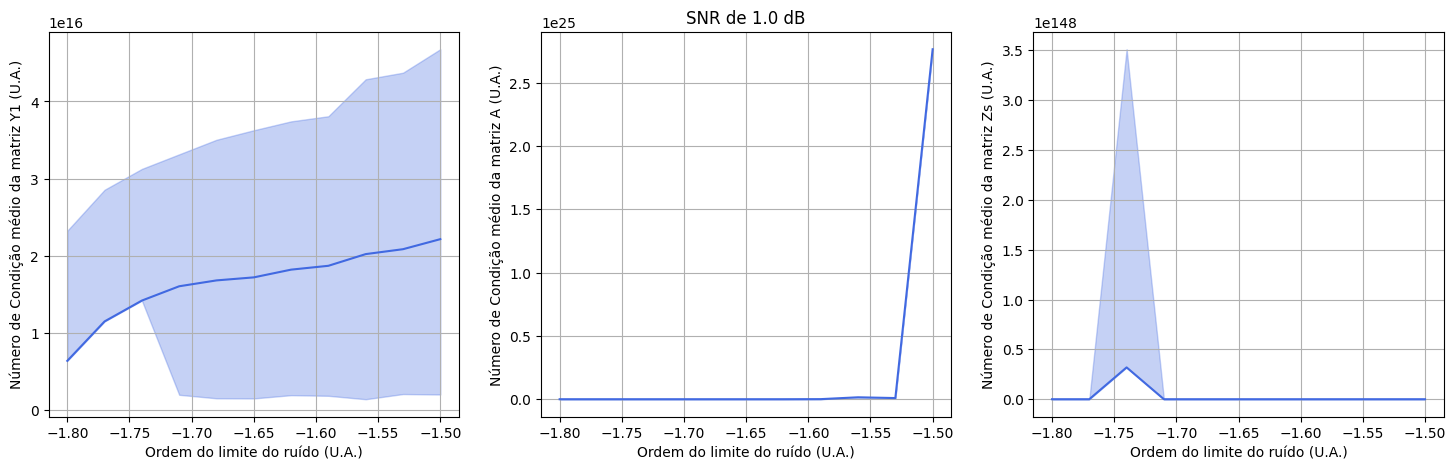

In [13]:
noise = 6 #avg 6 noise_3 9 tem um problema

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(-noise_threshold, avg_y1_cond, c = "royalblue")
plt.fill_between(-noise_threshold, avg_y1_cond - min_y1_cond, avg_y1_cond + max_y1_cond, color = "royalblue", alpha = 0.3)
plt.xlabel("Ordem do limite do ruído (U.A.)")
plt.ylabel("Número de Condição médio da matriz Y1 (U.A.)")
plt.grid()

plt.subplot(132)
plt.plot(-noise_threshold, avg_a_cond, c = "royalblue")
plt.fill_between(-noise_threshold, avg_a_cond - min_a_cond, avg_a_cond + min_a_cond, color = "royalblue", alpha = 0.3)
plt.title(f"SNR de {SNR} dB")
plt.xlabel("Ordem do limite do ruído (U.A.)")
plt.ylabel("Número de Condição médio da matriz A (U.A.)")
plt.grid()

plt.subplot(133)
plt.plot(-noise_threshold, avg_zs_cond, c = "royalblue")
plt.fill_between(-noise_threshold, avg_zs_cond - min_zs_cond, avg_zs_cond + max_zs_cond, color = "royalblue", alpha = 0.3)
plt.xlabel("Ordem do limite do ruído (U.A.)")
plt.ylabel("Número de Condição médio da matriz Zs (U.A.)")
# plt.ylim(-1e23, 1e23)
plt.grid()


Aparentemente a condição de matrizes mal-postas (ill-conditioned) acontece de maneira arbitrária apenas em SNRs pequenos ($< 10 dB$) no caso de corte do SVD.

## p grande (sem corte no svd) e variação dos SNRs

In [23]:
n_avgs = 10
shape = (sample_snrs.size, n_avgs)
y1_cond_no_p, a_cond_no_p, zs_cond_no_p = np.zeros(shape), np.zeros(shape), np.zeros(shape)
original_c_sigs_no_p = np.zeros((sample_snrs.size, n_avgs, 2048), dtype=np.complex128)

In [ ]:
SNR = sample_snrs[3]
print(SNR)

10.0


In [31]:
rerun = False
save = False
filename_end_2 = "_no_p_" + str(int(SNR))
folder_name = "files/"
subfolder_name = "matrix_condition/"

In [32]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)
sig, t = pymri.population_transverse_decay(t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft_ = sig_fft/np.nanmax(sig_fft)

if rerun == True:
    for j in range(n_avgs):
        for i in range(sample_snrs.size):
            c_sig_fft = awgn(sig_fft_, sample_snrs[i])
            original_c_sigs_no_p[i, j, :] = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

            y1_cond_no_p[i, j], a_cond_no_p[i, j], zs_cond_no_p[i, j] = pymri.assess_conditions(original_c_sigs_no_p[i, j, :], L, 30,
                                                                                    rcond=rcond, 
                                                                                    zero_filtering=zero_filtering)
            print(f"avg {j} SNR {sample_snrs[i]}")

In [33]:
if rerun == True and save == True:
    np.save(folder_name + subfolder_name + "y1_cond" + filename_end_2, y1_cond_no_p)
    np.save(folder_name + subfolder_name + "a_cond" + filename_end_2, a_cond_no_p)
    np.save(folder_name + subfolder_name + "zs_cond" + filename_end_2, zs_cond_no_p)
    np.save(folder_name + subfolder_name + "original_c_sigs" + filename_end_2, original_c_sigs_no_p)

In [34]:
if rerun == False:
    y1_cond_no_p = np.load(folder_name + subfolder_name   + "y1_cond" + filename_end_2 + ".npy")
    a_cond_no_p  = np.load(folder_name + subfolder_name   + "a_cond"  + filename_end_2 + ".npy")
    zs_cond_no_p = np.load(folder_name + subfolder_name   + "zs_cond" + filename_end_2 + ".npy")
    original_c_sigs_no_p = np.load(folder_name + subfolder_name   + "original_c_sigs" + filename_end_2 + ".npy")


In [35]:
avg_y1_cond_no_p = np.average(y1_cond_no_p, axis = 1)
avg_a_cond_no_p = np.average(a_cond_no_p, axis = 1)
avg_zs_cond_no_p = np.average(zs_cond_no_p, axis = 1)

std_y1_cond_no_p = np.std(y1_cond_no_p, axis = 1)
std_a_cond_no_p = np.std(a_cond_no_p, axis = 1)
std_zs_cond_no_p = np.std(zs_cond_no_p, axis = 1)

In [36]:
print(zs_cond_no_p[9, :])

[9.79570866e+04 1.67735739e+04 2.65240912e+04 5.05859469e+04
 2.40679719e+04 2.46923309e+04 8.89130443e+03 3.67044727e+04
 2.97539996e+04 1.15062252e+07]


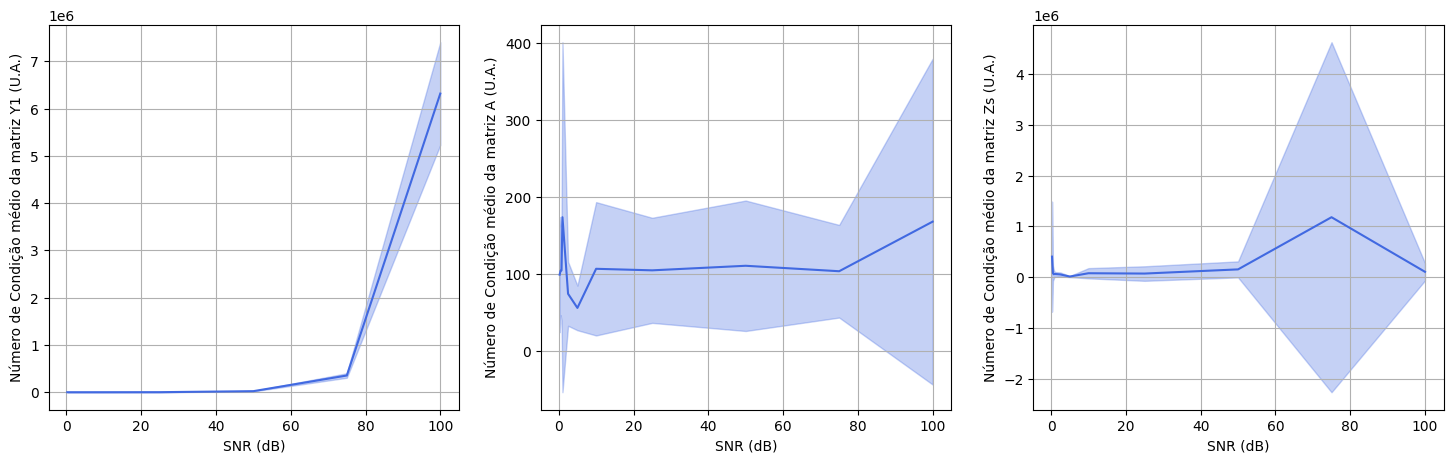

In [37]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(sample_snrs, avg_y1_cond_no_p, c = "royalblue")
plt.fill_between(sample_snrs, avg_y1_cond_no_p - std_y1_cond_no_p, avg_y1_cond_no_p + std_y1_cond_no_p, color = "royalblue", alpha = 0.3)
plt.xlabel("SNR (dB)")
plt.ylabel("Número de Condição médio da matriz Y1 (U.A.)")
plt.grid()

plt.subplot(132)
plt.plot(sample_snrs, avg_a_cond_no_p, c = "royalblue")
plt.fill_between(sample_snrs, avg_a_cond_no_p - std_a_cond_no_p, avg_a_cond_no_p + std_a_cond_no_p, color = "royalblue", alpha = 0.3)
plt.xlabel("SNR (dB)")
plt.ylabel("Número de Condição médio da matriz A (U.A.)")
plt.grid()

plt.subplot(133)
plt.plot(sample_snrs, avg_zs_cond_no_p, c = "royalblue")
plt.fill_between(sample_snrs, avg_zs_cond_no_p - std_zs_cond_no_p, avg_zs_cond_no_p + std_zs_cond_no_p, color = "royalblue", alpha = 0.3)
plt.xlabel("SNR (dB)")
plt.ylabel("Número de Condição médio da matriz Zs (U.A.)")
plt.grid()

## Conclusão preliminar

Aparentemente a instabilidade numérica parece estar associada necessariamente ao corte do SVD que de fato impacte o sistema, nas ordens anteriormente estabelecidas. Por mais que números de condicionamento da ordem de 1e6 até 1e21 sejam grandes e possam indicar problemas mal-postos, aparentemente o número condicionamento de que de fato rende problemas aqui é significativamente maior, de ordens maiores que 1e100. Esses nível de problema acontece especificamente na matriz `Zs`, que é composta pelos polos z elevados de $i = 0$ até $i = N-1$.

Qual deve ser o jeito de se abordar isso? Pesquisando áreas de instabilidade do algoritmo? Propondo de vez uma checagem intermediária para problemas mal-postos que interrompa o algoritmo? Implementação de um pré-condicionamento mediante identificação de um problema mal posto de ordem significativa?

No caso do pré-condicionamento, pesquisei pela regularização de Tikhonov, também chamada de Regressão de Ridge, e descobri que o scikit-learn tem uma classe que lida com isso: [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Nesse caso, suponho que se deva substituir apenas a etapa de mínimos quadrados no cálculo do R. As outras matrizes Y1 e A não parecem ser problemáticas para o processo do MPM.

[https://en.wikipedia.org/wiki/Ridge_regression](https://en.wikipedia.org/wiki/Ridge_regression)